<a href="https://colab.research.google.com/github/ChenXie-astro/corgietc/blob/main/01_Anatomy_of_an_Integration_Time_Calculation_HD163296.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anatomy of an Integration Time Calculation

This sheet walks through the basics of exposure time calculations and describes each of the required inputs.


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway"
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [2]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

Already up to date.
Processing /content/drive/MyDrive/corgietc/cgi_noise
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cgi_noise: filename=cgi_noise-1.3.0-py3-none-any.whl size=74152 sha256=20280f9dc8f63e80a3b3d16ce80ff16b6809194525387d86fc6591c40ca8eafd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1xv5mz28/wheels/f2/19/73/05bec0cc382a0c9da9b0f08a7c72962606b1c0cd7d9064b542
Successfully built cgi_noise
  Attempting uninstall: cgi_noise
    Found existing installation: cgi_noise 1.3.0
    Uninstalling cgi_noise-1.3.0:
      Successfully uninstalled cgi_noise-1.3.0
Already up to date.
Processing /content/drive/MyDrive/corgietc/corgietc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for corgietc: filename=corgietc-1.4.0-py3-none-any.whl size=28482 sha256=8026f49dca0df74de218a

### 🟠 Import jupyter widget for Colab

In [3]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [4]:
# import all required packages
import corgietc
import os
import json
import EXOSIMS.Prototypes.TargetList
import EXOSIMS.Prototypes.TimeKeeping
import copy
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

## Introduction

The Roman Coronagraph Exposure Time Calculator (ETC; ``corgietc``) is implemented by integrating two Python packages: ``cgi_noise`` and ``EXOSIMS``.  ``cgi_noise`` provides detailed modeling of the Roman Coronagraph and the definitions of the Roman Coronagraph observing modes (scenarios), along with basic models for astrophysical inputs.  ``EXOSIMS`` is a mission modeling framework, and provides its own ETCs, along with detailed astrophysical models and other useful utilities.  ``corgietc`` links these two packages together by implementing an ``EXOSIMS`` ``OpticalSystem`` implementation that calls ``cgi_noise`` for various calculations. This allows us to use the ``cgi_noise`` instrument model with the various inputs that can be computed by ``EXOSIMS``.

## Required Inputs for Computing Integration Time

Point-source integration time calculations are provided by the `calc_intTime` method of an `EXOSIMS` `OpticalSystem` module (such as ``corgietc``).  This method takes 7 required inputs and one optional one:

1. An `EXOSIMS` `TargetList` object: this includes all information about the targets (stars) that you might want to observe, along with utilities for computing stellar photometry.  Details on the `TargetList` class are available here: https://exosims.readthedocs.io/en/latest/targetlist.html and details on the stellar photometric modeling are available here: https://exosims.readthedocs.io/en/latest/concepts.html#photometry
2. The specific subset of targets you wish to compute integration times for (`sInds`).  `TargetList` stores all stellar information in equally-sized arrays, so this input is an array (or list, or other iterable) of which target indices you wish to select.  If your `TargetList` only contains one target, this input would be 0.
3. The surface brightness of local zodiacal light to assume for the calculation (`fZ`).  This must be an `astropy` `Quantity` object (https://docs.astropy.org/en/stable/units/index.html) whose contents are an array of either size 1 (in which case the same value is used for all calculations) or of an equal size to the `sInds` input. The units must be consistent with arcsec$^{-2}$. For details on the local zodiacal light model, see: https://exosims.readthedocs.io/en/latest/concepts.html#zodiacal-light
4. The intensity of the exo-zodiacal light to assume for the calculation (`JEZ`).  This must be structured in the same way as the `fZ` input, but with units consistent with photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$. For details on the exo-zodiacal light model, see: https://exosims.readthedocs.io/en/latest/concepts.html#exozodiacal-light
5. The desired $\Delta$magnitude between planet and star you wish to reach (`dMag`).  This must be an iterable of either size 1 (same for all calculations) or of equal size to `sInds`. This value sets the integration depth you wish to achieve.
6. The angular separation at which to perform calculations.  Because coronagraph performance varies as a function of angular separation, we must specify where in the throughput/contrast/etc. curves we wish to take our coronagraph performance values from.  That location is specified by this input, which must be an `astropy` `Quantity` array (with the same dimensionality assumptions as the other inputs) with units compatible with arcseconds. For more information on the parametrization of coronagraph performance, see here: https://exosims.readthedocs.io/en/latest/opticalsystem.html#standardized-coronagraph-parameters. Note that for the Roman coronagraph, we do **not** parametrize by stellar angular diameter - the assumption is that all of our target stars are fully unresolved.
7. The observing mode/scenario (`mode`).  An observing mode is the combination of a specific coronagraph with a specific detector in a specific bandpass.  It also defines the target signal-to-noise ratio (SNR) that you wish to achieve for your observation.  More details here: https://exosims.readthedocs.io/en/latest/opticalsystem.html#optical-system-definition
8. (Optional) An `EXOSIMS` `TimeKeeping` object.  As the name implies, a `TimeKeeping` object tracks elapsed mission time (amongst other time-associated utilities.  Time-on-orbit is an input into the integration time because we have a degradation model for our detector, which attempts to predict performance changes due to radiation exposure over the length of the mission.  If omitted, ``corgietc`` automatically assumes 21 months at L2. Note that the degradation model implemented by ``cgi_noise`` is only valid out to 63 months - past that, we cannot really trust the results.

## Constructing EXOSIMS Objects

All ``EXOSIMS`` objects are constructed via an input specification - a dictionary of key/value pairs, that can be read from a JSON-formatted file stored on disk.  Passing such an input specification to a `TargetList` automatically creates the `TargetList`, along with all other ``EXOSIMS`` modules required by the ``TargetList``, which includes the `OpticalSystem` and `ZodiacalLight` modules (the ones we need for doing our calculations).  More info on `EXOSIMS` objects is available here: https://exosims.readthedocs.io/en/latest/intro.html#framework

`corgietc` provides a default input specification, which we will now load:

In [5]:
# This loads the default input specification
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())

The component of the input specification that tells `EXOSIMS` what types of objects to build is called `modules`:

In [6]:
specs["modules"]

{'PlanetPopulation': ' ',
 'StarCatalog': ' ',
 'OpticalSystem': '$CORGIETC_DATA_DIR/../corgietc.py',
 'ZodiacalLight': 'Stark',
 'BackgroundSources': 'GalaxiesFaintStars',
 'PlanetPhysicalModel': 'ForecasterMod',
 'Observatory': ' ',
 'TimeKeeping': ' ',
 'PostProcessing': ' ',
 'Completeness': ' ',
 'TargetList': ' ',
 'SimulatedUniverse': ' ',
 'SurveySimulation': ' ',
 'SurveyEnsemble': ' '}

All entries that are blank spaces indicate that the prototype (default) object type should be built.  As you can see, the template input specification sets the `OpticalSystem` to `corgietc`.  By leaving the `StarCatalog` module blank, we are generating a fake catalog of stars (in fact, just one star). Let's instantiate the `TargetList` and take a look.

In [7]:
# Build the targetlist object
# create a copy of the default input specification
specs2 = copy.deepcopy(specs)
# update the modules dictionary to use the HIPfromSimbad star catalog
specs2["modules"]["StarCatalog"] = "HIPfromSimbad"
# generate the target list

# HD163296: HIP87819
# HD191089: HIP99273
TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs2), catalogpath=[87819])        # HD163296
# TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs2), catalogpath=[99273])      # HD191089

# TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs2))
OS = TL.OpticalSystem

/usr/local/lib/python3.12/dist-packages/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported HIPfromSimbad (implementation) from EXOSIMS.StarCatalog.HIPfromSimbad
Imported corgietc (named file) from /content/drive/[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
1 targets imported from star catalog.
1 targets remain after removing those where spectral class cannot be established.
1 targets remain after removing white dwarfs and subdwarfs
1 targets remain after nan filtering.
1 targets remain after removing zero luminosity targets.
Cache file not found for mode 6534987b1b37fa7a5002481940edacde. Computing exozodi color facto

Notice that we used a copy of the input specification rather than directly sending it to the `TargetList`.  You can actually do either, but `EXOSIMS` objects will modify the input specification as they pass it around, so if you want to retain the original, you have to use a copy.

We can inspect the single fake target we created:

In [8]:
# let's check on the target
print(f"Name: {TL.Name}")
print(f"is located at {TL.coords}")
print(f"and has a V band magnitude of {TL.Vmag}")
# print(TL.Vmag.type)

Name: ['HIP 87819']
is located at <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(269.08870077, -21.95607551, 100.96624698)]>
and has a V band magnitude of [6.8499999]


The template specifications have created a 5th magnitude star (in V band) located 10 parsecs away.

While we're here, we'll also create the optional `TimeKeeping` object, and set the current mission time to 21 months (matching the default):

In [9]:
# create a Timekeeping object and advance the mission time a bit
TK = EXOSIMS.Prototypes.TimeKeeping.TimeKeeping(missionLife = 5.25)   # 63 months in years is 5.25, 21 months is 1.75
TK.allocate_time(21*30.4375*u.d);

OBendTimes is: [1917.5625] d


## Generating Integration Time Calculation Inputs

We will now generate input values for each of the `calc_intTime` inputs.  

### 1. `TargetList`
We already have our `TargetList` object, so this is done.

### 2. `sInds`
The target listincludes only one target, so:

In [10]:
sInds = 0

### 3. `fZ`
For the local zodiacal light, the `TargetList` provides an attribute with a default value (equivalent to a local zodi brightness of 23 mag arcsec$^{-2}$:

In [11]:
fZ = np.repeat(TL.ZodiacalLight.fZ0, 1)
fZ

<Quantity [6.30957344e-10] 1 / arcsec2>

Note the use of the `numpy` `repeat` method to make this an iterable (as required).

### 7. `mode`

We're going to go a bit out of order and specify our observing mode next, as it is required for some of the other things we need to compute. All observing modes are stored in `OpticalSystem` attribute `observingModes`.  For `corgietc`, all modes have a `Scenario` keyword, and we can print these out:

In [12]:
for mode in OS.observingModes:
    print(mode["Scenario"])

OPT_IMG_NFB1_HLC
CON_IMG_NFB1_HLC
OPT_IMG_WFB4_SPC
CON_IMG_WFB4_SPC
OPT_SPEC_NFB3_SPC
CON_SPEC_NFB3_SPC


We will pick the first mode from the list - optimistic HLC with imaging in Band 1:

In [13]:
mode = OS.observingModes[3]
print(mode)

{'instName': 'WF_B4_Imager', 'systName': 'CON_B4_SPC', 'Scenario': 'CON_IMG_WFB4_SPC', 'lam': <Quantity 825. nm>, 'SNR': 5.0, 'StrayLight_Data': '$CGI_NOISE_DATA_DIR/Photometry/STRAY_CBE_250605.csv', 'pp_Factor_CBE': 2.0, 'timeMultiplier': 1.0, 'detectionMode': False, 'inst': {'name': 'WF_B4_Imager', 'CritLam': <Quantity 500. nm>, 'pixelSize': <Quantity 1.3e-05 m>, 'QE': <function OpticalSystem.populate_scienceInstruments.<locals>.<lambda> at 0x7ac641b49120>, 'DET_QE_Data': <cgi_noise.loadCSVrow.loadCSVrow object at 0x7ac641b40c80>, 'DET_CBE_Data': <cgi_noise.loadCSVrow.loadCSVrow object at 0x7ac641b434a0>, 'optics': 0.5, 'FoV': <Quantity 10. arcsec>, 'pixelNumber': 1000.0, 'pixelScale': <Quantity 0.02182235 arcsec>, 'idark': <Quantity 0.0001 1 / s>, 'sread': 1e-06, 'texp': <Quantity 100. s>, 'Rs': 1.0, 'lenslSamp': 1.0, 'focal': <Quantity 134.07212406 m>, 'fnumber': 56.73809735954825, 'compbeamD': <Quantity 0.005 m>, 'fnlFocLen': <Quantity 0.26 m>, 'PSF_x_lamD': 0.942, 'PSF_y_lamD': 0

### 4. `JEZ`
Similarly, the `TargetList` pre-computes the exozodi of all targets for all observing modes at 1 AU separation.  We can then scale these to the actual planet location desired.  In this case, let's assume a planet at 4.1536 AU (to match a default used for testing in ``cgi_noise``):

In [14]:
JEZ = TL.JEZ0[mode["hex"]]/(4.1536**2)*0
JEZ

<Quantity [0.] ph / (s arcsec2 m2)>

There was a lot going on in that last call - basically, `TL.JEZ0` is a dictionary of values linked to each mode, indexed by a unique string describing that mode, that is stored in the mode's dictionary under key `hex`.  So, we pulled the value associated with the our selected observing mode, and then scaled it by the distance to the planet (in AU) squared. One important caveat, the exozodi is scaled not only by the planet's location, but by the assumed inclination of the exo-zodiacal disk (i.e., the exosystem's inclination).  By our default input specification, we have assumed that the system is edge-on, which is the worst-case for the exozodi contribution.

### 5. `dMag`
We will just set this to an arbitrary value for now (again selected to match ``cgi_noise`` test defaults.

In [15]:
dMag = np.array([17.05]) #HD63296
# dMag = np.array([18.47])
# dMag = np.array([16.28]) # HD191089

### 6. `WA`

We wish to use 7.5 $\lambda/D$ as the coronagraph operating point (again matching ``cgi_noise`` test defaults). The input needs to have physical angle values, so we will scale it by the mode's wavelength and the Roman primary diameter:

In [16]:
WA = np.array([9]) * (mode["lam"]/OS.pupilDiam).to(u.arcsec, equivalencies=u.dimensionless_angles()) #HD163296
# WA = np.array([12.62]) * (mode["lam"]/OS.pupilDiam).to(u.arcsec, equivalencies=u.dimensionless_angles())  #HD191089
WA

<Quantity [0.64812365] arcsec>

Note the use of the `astropy` equivalencies to make sure that we are properly treating $\lambda/D$ as an angle.

## Running the integration time calculation

We have all the inputs set up, so now it's just a matter of calling the method:

In [17]:
intTimes = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode, TK=TK)
intTimes.to(u.s)

<Quantity [3927.04861781] s>

Finally, let's try this for a range of integration depths.  We will set up a range of $\Delta$mag values (and then repeating the `sInd` such that we compute an intergration time for each one).

OPT_IMG_WFB4_SPC
5
[4061.23876799] s
CON_IMG_WFB4_SPC
5
[4570.09147105] s


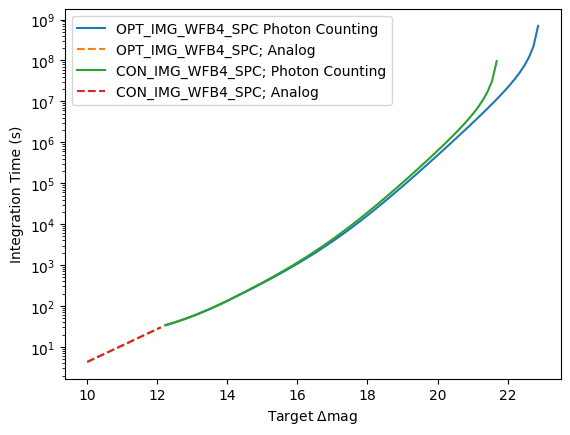

In [18]:
dMags = np.linspace(10, 23, 100)
mode1 = list(filter(lambda mode: mode['Scenario'] == 'OPT_IMG_WFB4_SPC', OS.observingModes))[0]
mode1["contrast_degradation"] = 10
print(mode1["Scenario"])
mode1["SNR"] = 5
print(mode1["SNR"])

Cp1, Cb1, Csp1, extra1 = OS.Cp_Cb_Csp(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode1, TK=TK, returnExtra=True)
OS.forcePhotonCounting = False
intTimes_auto1 = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode1, TK=TK)
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode1, TK=TK).to(u.s))


# mode2 = OS.observingModes[3]
# print(mode2["Scenario"])
mode2 = list(filter(lambda mode: mode['Scenario'] == 'CON_IMG_WFB4_SPC', OS.observingModes))[0]
mode2["contrast_degradation"] = 3.3
print(mode2["Scenario"])
mode2["SNR"] = 5
print(mode2["SNR"])

Cp2, Cb2, Csp2, extra2 = OS.Cp_Cb_Csp(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode2, TK=TK, returnExtra=True)
OS.forcePhotonCounting = False
intTimes_auto2 = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode2, TK=TK)
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode2, TK=TK).to(u.s))

plt.figure()
plt.semilogy(dMags[extra1["photonCounting"]], intTimes_auto1[extra1["photonCounting"]].to(u.s), label="{0} Photon Counting".format(mode1["Scenario"]))
plt.semilogy(dMags[~extra1["photonCounting"]], intTimes_auto1[~extra1["photonCounting"]].to(u.s), '--', label="{0}; Analog".format(mode1["Scenario"]))

plt.semilogy(dMags[extra2["photonCounting"]], intTimes_auto2[extra2["photonCounting"]].to(u.s), label="{0}; Photon Counting".format(mode2["Scenario"]))
plt.semilogy(dMags[~extra2["photonCounting"]], intTimes_auto2[~extra2["photonCounting"]].to(u.s), '--', label="{0}; Analog".format(mode2["Scenario"]))

plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes_auto1.to(u.s).unit})")
plt.legend();

from astropy.io import fits
output_cube = np.zeros((3,dMags.shape[0]))
output_cube[0] = dMags
output_cube[1] = intTimes_auto1.to(u.s)
output_cube[2] = intTimes_auto2.to(u.s)
fits.writeto('/content/drive/MyDrive/{0}_etc.fits'.format(TL.Name), output_cube, overwrite=True)

[0.44648518] arcsec
OPT_IMG_NFB1_HLC
5
[590.79384234] s
CON_IMG_NFB1_HLC
5
[946.20112596] s


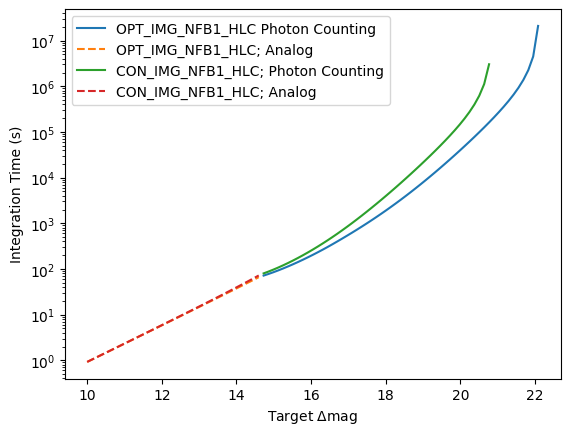

In [19]:
dMags = np.linspace(10, 23, 100)
WA = np.array([6.2]) * (mode["lam"]/OS.pupilDiam).to(u.arcsec, equivalencies=u.dimensionless_angles())
print(WA)
mode1 = list(filter(lambda mode: mode['Scenario'] == 'OPT_IMG_NFB1_HLC', OS.observingModes))[0]
mode1["contrast_degradation"] = 10
print(mode1["Scenario"])
mode1["SNR"] = 5
print(mode1["SNR"])

Cp1, Cb1, Csp1, extra1 = OS.Cp_Cb_Csp(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode1, TK=TK, returnExtra=True)
OS.forcePhotonCounting = False
intTimes_auto1 = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode1, TK=TK)
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode1, TK=TK).to(u.s))


# mode2 = OS.observingModes[3]
# print(mode2["Scenario"])
mode2 = list(filter(lambda mode: mode['Scenario'] == 'CON_IMG_NFB1_HLC', OS.observingModes))[0]
mode2["contrast_degradation"] = 3.3
print(mode2["Scenario"])
mode2["SNR"] = 5
print(mode2["SNR"])

Cp2, Cb2, Csp2, extra2 = OS.Cp_Cb_Csp(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode2, TK=TK, returnExtra=True)
OS.forcePhotonCounting = False
intTimes_auto2 = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode2, TK=TK)
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode2, TK=TK).to(u.s))

plt.figure()
plt.semilogy(dMags[extra1["photonCounting"]], intTimes_auto1[extra1["photonCounting"]].to(u.s), label="{0} Photon Counting".format(mode1["Scenario"]))
plt.semilogy(dMags[~extra1["photonCounting"]], intTimes_auto1[~extra1["photonCounting"]].to(u.s), '--', label="{0}; Analog".format(mode1["Scenario"]))

plt.semilogy(dMags[extra2["photonCounting"]], intTimes_auto2[extra2["photonCounting"]].to(u.s), label="{0}; Photon Counting".format(mode2["Scenario"]))
plt.semilogy(dMags[~extra2["photonCounting"]], intTimes_auto2[~extra2["photonCounting"]].to(u.s), '--', label="{0}; Analog".format(mode2["Scenario"]))

plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes_auto1.to(u.s).unit})")
plt.legend();

from astropy.io import fits
output_cube = np.zeros((3,dMags.shape[0]))
output_cube[0] = dMags
output_cube[1] = intTimes_auto1.to(u.s)
output_cube[2] = intTimes_auto2.to(u.s)
fits.writeto('/content/drive/MyDrive/{0}_etc.fits'.format(TL.Name), output_cube, overwrite=True)

[0.00000000e+00 4.08256326e-04 1.63318487e-03 3.67526446e-03
 6.53529369e-03 1.02143917e-02 1.47139992e-02 2.00358799e-02
 2.61821224e-02 3.31551421e-02 4.09576835e-02 4.95928231e-02
 5.90639722e-02 6.93748807e-02 8.05296404e-02 9.25326892e-02
 1.05388816e-01 1.19103164e-01 1.33681239e-01 1.49128911e-01
 1.65452423e-01 1.82658397e-01 2.00753841e-01 2.19746153e-01
 2.39643135e-01 2.60452994e-01 2.82184357e-01 3.04846277e-01
 3.28448242e-01 3.53000186e-01 3.78512503e-01 4.04996051e-01
 4.32462173e-01 4.60922702e-01 4.90389978e-01 5.20876862e-01
 5.52396749e-01 5.84963586e-01 6.18591884e-01 6.53296740e-01
 6.89093852e-01 7.25999536e-01 7.64030751e-01 8.03205115e-01
 8.43540930e-01 8.85057202e-01 9.27773666e-01 9.71710815e-01
 1.01688992e+00 1.06333306e+00 1.11106316e+00 1.16010400e+00
 1.21048027e+00 1.26221760e+00 1.31534259e+00 1.36988284e+00
 1.42586701e+00 1.48332483e+00 1.54228720e+00 1.60278616e+00
 1.66485500e+00 1.72852830e+00 1.79384195e+00 1.86083324e+00
 1.92954093e+00 2.000005

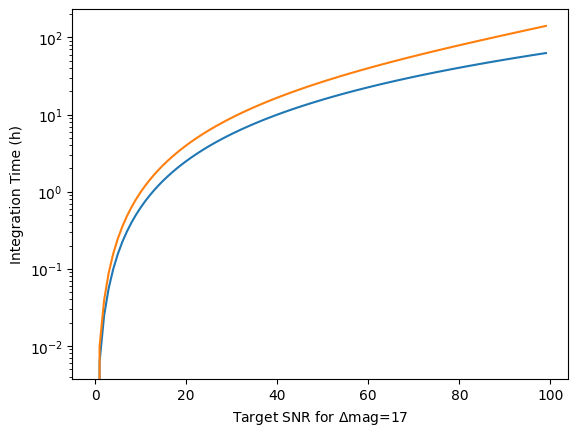

In [21]:
dMag = np.array([17])
# try SNRs from 1 to 40
SNRs = np.arange(100)
intTimes1 = np.zeros(len(SNRs))*u.d
intTimes2 = np.zeros(len(SNRs))*u.d
for j, SNR in enumerate(SNRs):
    mode1["SNR"] = SNR
    mode2["SNR"] = SNR
    intTimes1[j] = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode1, TK=TK)
    intTimes2[j] = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode2, TK=TK)
    # print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode2, TK=TK).to(u.s))

plt.figure()
print(intTimes2)
plt.semilogy(SNRs, intTimes1.to(u.hr))
plt.semilogy(SNRs, intTimes2.to(u.hr))
plt.xlabel(rf"Target SNR for $\Delta$mag={dMag[0]}")
plt.ylabel(f"Integration Time ({intTimes1.to(u.hr).unit})")
# plt.title(fr"Maximum Achievable SNR $\approx$ {np.min(SNRs[np.isnan(intTimes)]) :.2f}");

from astropy.io import fits
output_cube = np.zeros((3,SNRs.shape[0]))
output_cube[0] = SNRs
output_cube[1] = intTimes1.to(u.hr)
output_cube[2] = intTimes2.to(u.hr)
fits.writeto('/content/drive/MyDrive/{0}_snr.fits'.format(TL.Name), output_cube, overwrite=True)


### Saturation $\Delta$mag

Note that the plot does not seem to actually reach the maximum $\Delta$mag value that we specified.  This is because that value is infeasible for this particular observation.  When this happens, `calc_intTime` returns a NaN value - for this particular observing scenario, target, and zodi levels, that occurs at a $\Delta$mag of ~22.  

Note that this was only an approximation, based on a line search over a discrete set of input $\Delta$mag values.  However, we have a method for doing the exact calculation:

In [ ]:
sat_dMag = OS.calc_saturation_dMag(TL, [sInds], fZ, JEZ, WA, mode, TK=TK)
sat_dMag

This corresponds to a flux ratio of:

In [ ]:
10**(-0.4*sat_dMag)

**Important** Remember that, in general, this is what you could achieve if you had effectively infinite integration time (in this particular example, you can get close to this value with ~10 days of integration time).  It is also the *optimistic* version of this observing mode.  Let's see what happens when we switch to the *conservative* version of the mode:

In [ ]:
mode2 = list(filter(lambda mode: mode['Scenario'] == 'CON_IMG_NFB1_HLC', OS.observingModes))[0]
mode2["Scenario"]

In [ ]:
intTimes2 = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode2, TK=TK)
plt.figure()
plt.semilogy(dMags, intTimes2)
plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes2.unit})")
plt.title(fr"Maximum Achievable $\Delta$mag $\approx$ {np.min(dMags[np.isnan(intTimes2)]) :.2f}");

### Photon-Counting vs Analog Observations

You might have noticed another feature in the last two plots - a small deviation in the curve occurring between $\Delta$mag of 17 and 18 in the optimistic case, and 16 and 17 in the conservative case. One of the things that is happening during an integration time calculation is that the code is making a determination of whether to run the detector in photon counting or analog mode (for details on these, see Nemati et al. (2023) https://doi.org/10.1117/1.JATIS.9.3.034007).  The determination is made by approximating the counts per pixel per frame, and applying a threshold value, which is stored in `OpticalSystem` attribute `frameThresh` (units of e-/pixel/frame).  The default value is:

In [ ]:
OS.frameThresh

Exposures where the expected counts exceed this threshold are run, by default, in analog mode.  We can modify this threshold at any time by overwriting the parameter, or can force the photon counting mode to always be used by setting attribute `forcePhotonCounting`.  Let's take a look:

In [ ]:
OS.forcePhotonCounting = True
intTimes_allPhotonCounting = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode, TK=TK)
plt.figure()
plt.semilogy(dMags, intTimes_allPhotonCounting)
plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes_allPhotonCounting.unit})");

We can see that by forcing the photon counting mode to be used everywhere, we have smoothed out the curve, but we need to be careful: if we extend to lower $\Delta$mag values in this mode, we will eventually get the counter-intuitive result where we actually get longer integration times for brighter planets:

In [ ]:
dMags2 = np.linspace(12, 22, 100)
OS.forcePhotonCounting = True
intTimes_allPhotonCounting2 = OS.calc_intTime(TL, [sInds]*len(dMags2), fZ, JEZ, dMags2, WA, mode, TK=TK)
OS.forcePhotonCounting = False
intTimes_auto2 = OS.calc_intTime(TL, [sInds]*len(dMags2), fZ, JEZ, dMags2, WA, mode, TK=TK)
plt.figure()
plt.semilogy(dMags2, intTimes_allPhotonCounting2, label="Photon-Counting")
plt.semilogy(dMags2, intTimes_auto2, '--', label="Auto-Switching")
plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes_allPhotonCounting.unit})")
plt.legend();

**Important** The default threshold value works reasonably well for the example here, but will not necessarily be right in all instances.  It is possible (although quite computationally intensive) to figure out the threshold value that ensure minimum resulting integration time for any set of inputs, but a much simpler approach is to compute integration times in regions where either photon counting or analog exposures may work best in both modes and to take the smaller of the two results as the right answer.

If you are operating with the auto-switching turned on (recommended) and wish to see exactly which mode was assumed for each integration time, you can do so by calling the helper method `Cp_Cb_Csp` with keyword `returnExtra` set to `True`.  This method is called by `calc_intTime` and returns the count rates of the planet and background, as well as the variance of the residual speckle rate.  `returnExtra=True` also returns a dictionary of many intermediate values used in the calculation of these rates, including whether photon counting was assumed:

In [ ]:
Cp, Cb, Csp, extra = OS.Cp_Cb_Csp(TL, [sInds]*len(dMags2), fZ, JEZ, dMags2, WA, mode, TK=TK, returnExtra=True)
plt.figure()
plt.semilogy(dMags2[extra["photonCounting"]], intTimes_auto2[extra["photonCounting"]], label="Photon Counting")
plt.semilogy(dMags2[~extra["photonCounting"]], intTimes_auto2[~extra["photonCounting"]], '--', label="Analog")
plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes_allPhotonCounting.unit})")
plt.legend();

### Be Careful About Your Inputs

Let's now look at one of the spectroscopy modes. This time, we'll identify it by name:

In [ ]:
specmode = list(
    filter(lambda mode: mode["Scenario"] == "OPT_SPEC_NFB3_SPC", OS.observingModes)
)[0]
print(specmode["Scenario"])

We'll repeat the same integration time calculation as above:

In [ ]:
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, specmode, TK=TK).to(u.s))

One note of caution here: we used exactly the same inputs for ``fZ`` and ``JEZ``, but remember that this mode has a different bandpass and central wavelength, meaning that these values might not be appropriate.  For more on this, see Notebook 04 - Simulating Zodiacal Light.

Finally, let's do a test calculation on the wide-field imaging mode:

In [ ]:
wfmode = list(
    filter(lambda mode: mode["Scenario"] == "OPT_IMG_WFB4_SPC", OS.observingModes)
)[0]
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, wfmode, TK=TK).to(u.s))

Oh no! What happened?  We're targeting the same $\Delta$mag value as in our previous calculations, so why was this one infeasible?  Remember that this mode has a very different inner and outer working angle form the other two we've already looked at:

In [ ]:
for m in [mode, specmode, wfmode]:
    print(f'{m["Scenario"]}: IWA={m["IWA"]}, OWA={m["OWA"]}')
print(f"Requested WA: {WA}")

So, while this angular separation that we're currently using worked fine for the narrow-field modes, it falls below the inner working angle of the wide-field mode.  We'll redo the calculation exactly at this mode's IWA:

In [ ]:
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, np.repeat(wfmode["IWA"],1), wfmode, TK=TK).to(u.s))

## Signal to Noise

We mentioned SNR very briefly when introducing the `mode` variable, but have largely ignored it since.  However, the desired SNR of the observation is a key parameter that influences the integration time calculation to a great extent.

The SNR is stored in the `mode` definition, and, by default, is set to 5 for all of our modes:


In [ ]:
mode["SNR"]

While certain mode parameters can only be set at instantiation (i.e., when the `OpticalSystem` object is first being defined), `SNR` can be modified at any time:

In [ ]:
mode["SNR"] = 10
print(mode["SNR"])
print(OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode, TK=TK).to(u.s))

We can see doubling the SNR (from 5 to 10) has approximately quadrupled the required integration time.  This makes sense,  as SNR typically varies as the square root of the integration time, with the caveat that you are well away from the systematic noise floor of the system. Let's take a look:

In [ ]:
intTimes_SNR10 =  OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode, TK=TK)
plt.figure()
plt.semilogy(dMags, intTimes, label="SNR=5")
plt.semilogy(dMags, intTimes_SNR10, label="SNR=10")
plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes.unit})")
plt.legend();

We can also perform sweeps over ranges of SNRs for a fixed $\Delta$mag.  For this calculation, we'll choose a somewhat more challenging $\Delta$ mag value:

In [ ]:
dMag = np.array([20])
# try SNRs from 1 to 40
SNRs = np.arange(41)
intTimes = np.zeros(len(SNRs))*u.d
for j, SNR in enumerate(SNRs):
    mode["SNR"] = SNR
    intTimes[j] = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode, TK=TK)

plt.figure()
plt.semilogy(SNRs, intTimes)
plt.xlabel(rf"Target SNR for $\Delta$mag={dMag[0]}")
plt.ylabel(f"Integration Time ({intTimes.unit})")
plt.title(fr"Maximum Achievable SNR $\approx$ {np.min(SNRs[np.isnan(intTimes)]) :.2f}");

Just as with our previous calculation of integration times for varying $\Delta$mag values, once we hit the noise floor of the system, integration times are returned as NaN values, which we can use as an approximate diagnostic for what magnitude of SNR corresponds to the noise floor for a given $\Delta$mag.  We can also compute this value exactly, by noting that the denominator of the integration time expression is:
$$C_p^2 - \left(\mathrm{SNR} \cdot C_{sp}\right)^2$$
where $C_p$ is the planet signal rate (photons/time) and $C_{sp}$ is the standard deviation of the residual speckle rate (the portion of star light that is not suppressed by the coronagraph or post-processing.  If this rate did not vary (i.e., if this value was zero) then we could get to infinite SNR given infinite integration time.  It is this rate that sets the system noise floor.  We can therefore find the maximum possible SNR by finding the SNR value for which this expression equals zero:

In [ ]:
Cp, Cb, Csp = OS.Cp_Cb_Csp(TL, sInds, fZ, JEZ, dMag, WA, mode)
SNRmax = Cp/Csp
print(SNRmax)

## Changing Target Attributes

Unlike the `SNR` parameter of the `observingMode` dictionary, attributes of the `TargetList` object representing star properties should **not** be changed after the object is instantiated.  This is because there are many calculations done based on these values at the time the object is created, and none of these calculations will be re-run if you simply reach into the object and change some value.

For example, let's say we wish to change the V-band magnitude of the one target in our synthetic target list:

In [ ]:
# restore original values:
dMag = np.array([17.5])
mode["SNR"] = 5
print(f"Initial value of Vmag: {TL.Vmag}")
TL.Vmag[0] = 8.5
print(f"New value of Vmag: {TL.Vmag}")

While we were able to update the value, using it for calculations will show that the change produces no effect:

In [ ]:
OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode, TK=TK).to(u.s)

As we can see, the computed integration time is exactly what we previously found, despite assuming a different star brightness.  This is because the actual stellar flux being used was computed based on this magnitude at the time when the `TargetList` object was defined, and has not been re-calculated when we manually updated the magnitude.  In order to do this properly, we need to define a new `TargetList` object with the magnitude we want.  For the synthetic star catalog we are currently using, this is controlled by input keyword `VmagFill`:

In [ ]:
specs["VmagFill"] = 2
TL2 = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs))

Let's verify that this had the intended effect:

In [ ]:
print(TL2.Vmag)

How can we tell that anything else has changed? For that, we can look at the `starFlux` attribute of our two target lists:

In [ ]:
print(f"Target List 1: Flux: {TL.star_fluxes[mode['hex']][sInds]}")
print(f"Target List 2: Flux: {TL2.star_fluxes[mode['hex']][sInds]}")

As expected, the flux has gone up by approximately an order of magnitude.  We can now use this new target list to perform the integration time calculation:

In [ ]:
OS.calc_intTime(TL2, sInds, fZ, JEZ, dMag, WA, mode, TK=TK).to(u.s)

So far, we have been doing all of our calculations on a synthetic target list of just one star, but this can be very inefficient if you are interested in evaluating how integration times vary as a function of stellar magnitude.  Fortunately, we are able to create multi-star target lists (see notebook 3 - Constructing Your Target List).  For now, let's take a quick look at how to build a synthetic target list that only varies the V band magnitude:

In [ ]:
specs["VmagFill"] = np.linspace(0, 10, 100)
specs["ntargs"] = len(specs["VmagFill"])
TL3 = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs))
print(TL3.Vmag)

We now have more than one target index, so we must update our `sInds` input:

In [ ]:
sInds2 = np.arange(TL3.nStars)
intTimes_v_Vmag = OS.calc_intTime(TL3, sInds2, fZ, JEZ, dMag, WA, mode, TK=TK).to(u.s)
plt.figure()
plt.semilogy(TL3.Vmag, intTimes_v_Vmag)
plt.xlabel(r"Target V mag")
plt.ylabel(f"Integration Time ({intTimes_v_Vmag.unit})");

Once again, we see a slight discontinuity in the curve, and, once again, this is due to the switch from photon counting to analog frames. Note also that the underlying model does not include any contrast degradation expected due to worsening HOWFS performance on dimmer targets.  Because of this, the code generates a warning for any targets with V>9.